<a href="https://colab.research.google.com/github/johanjun/Google_Machine_Learning_Bootcamp_KR_2021/blob/main/kaggle/RSNA_MICCAI_BRAIN_TUMOR/rsna_miccai_brain_tumor_johanjun_0929_effi(allsame).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pydicom

     |████████████████████████████████| 2.0 MB 10.1 MB/s 


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm
import random
# import pydicom
import cv2
import pickle

import matplotlib.pyplot as plt
import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [3]:
data_dir = '/content/drive/MyDrive/Google_Machine_Learning_Bootcamp_KR_2021/RSNA_MICCAI/data/rsna-miccai/'

In [6]:
train_df = pd.read_csv(data_dir + "train_labels.csv")
test_df = pd.read_csv(data_dir + "sample_submission.csv")

In this discussion a competition host has notified that there are some issues with these 3 cases
Patient IDs -

1. 00109 (FLAIR images are blank)
2. 00123 (T1w images are blank)
3. 00709 (FLAIR images are blank)
<br><br>Hence these can be excluded

In [7]:
#refer: https://www.kaggle.com/arnabs007/part-1-rsna-miccai-btrc-understanding-the-data
EXCLUDE = [109, 123, 709]
train_df = train_df[~train_df.BraTS21ID.isin(EXCLUDE)]

In [8]:
TYPES = ["FLAIR", "T1w", "T1wCE", "T2w"] #mpMRI scans

In [9]:
def load_dicom(path, size = 64): #load DICOM files
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array #returns a numpy.ndarray containing the pixel data
    if np.max(data) != 0:
        data = data / np.max(data) #standardizes so that the pixel values are between 0 and 1
    data = (data * 255).astype(np.uint8) #rescales to 0 and 255
    return cv2.resize(data, (size, size))

In [10]:
def get_all_image_paths(BraTS21ID, image_type, folder="train"): #get an array of all the images of a particular type or a particular patient id
    assert(image_type in TYPES) #only in types
    patient_path = os.path.join(data_dir + "%s/" % folder, str(BraTS21ID).zfill(5)) #다른 폴더일 수도 있음
    #print(lambda x: int(x[:-4].split("-")[-1]))
    
    paths = sorted(glob.glob(os.path.join(patient_path, image_type, "*")), key=lambda x: int(x[:-4].split("-")[-1])) #sort
    #print(paths)
    
    num_images = len(paths)
    
    start = int(num_images * 0.25)
    end = int(num_images * 0.75)
    if num_images < 10:
        jump = 1
    else:
        jump = 3
        
    return np.array(paths[start:end:jump])

In [11]:
def get_all_images(BraTS21ID, image_type, folder="train", size=225):
    return [load_dicom(path, size) for path in get_all_image_paths(BraTS21ID, image_type, folder)]

In [12]:
def get_all_data_train(image_type):
    global train_df
    
    X = []
    y = []
    train_ids = []

    for i in tqdm(train_df.index):
        tmp_x = train_df.loc[i]
        images = get_all_images(int(tmp_x["BraTS21ID"]), image_type, "train", IMAGE_SIZE)
        label = tmp_x["MGMT_value"]

        X += images
        y += [label] * len(images)
        train_ids += [int(tmp_x["BraTS21ID"])] * len(images)
        assert(len(X) == len(y))
    return np.array(X), np.array(y), np.array(train_ids)

def get_all_data_test(image_type):
    global test_df
    
    X = []
    test_ids = []

    for i in tqdm(test_df.index):
        tmp_x = test_df.loc[i]
        images = get_all_images(int(tmp_x["BraTS21ID"]), image_type, "test", IMAGE_SIZE)
        X += images
        test_ids += [int(tmp_x["BraTS21ID"])] * len(images)

    return np.array(X), np.array(test_ids)

In [13]:
#pickling
with open(data_dir+'X_T1wCE_allsame.pkl', 'rb') as f:
  X_T1wCE = pickle.load(f)

with open(data_dir+'y_T1wCE_allsame.pkl', 'rb') as f:
  y_T1wCE = pickle.load(f)

with open(data_dir+'train_idt_T1wCE_allsame.pkl', 'rb') as f:
  train_idt_T1wCE = pickle.load(f)

with open(data_dir+'X_test_T1wCE_allsame.pkl', 'rb') as f:
  X_test_T1wCE = pickle.load(f)

with open(data_dir+'test_idt_T1wCE_allsame.pkl', 'rb') as f:
  test_idt_T1wCE = pickle.load(f)

In [14]:
#pickling
with open(data_dir+'X_FLAIR_allsame.pkl', 'rb') as f:
  X_FLAIR = pickle.load(f)

with open(data_dir+'y_FLAIR_allsame.pkl', 'rb') as f:
  y_FLAIR = pickle.load(f)

with open(data_dir+'train_idt_FLAIR_allsame.pkl', 'rb') as f:
  train_idt_FLAIR = pickle.load(f)

with open(data_dir+'X_test_FLAIR_allsame.pkl', 'rb') as f:
  X_test_FLAIR = pickle.load(f)

with open(data_dir+'test_idt_FLAIR_allsame.pkl', 'rb') as f:
  test_idt_FLAIR = pickle.load(f)

In [15]:
#pickling
with open(data_dir+'X_T2w_allsame.pkl', 'rb') as f:
  X_T2w = pickle.load(f)

with open(data_dir+'y_T2w_allsame.pkl', 'rb') as f:
  y_T2w = pickle.load(f)

with open(data_dir+'train_idt_T2w_allsame.pkl', 'rb') as f:
  train_idt_T2w = pickle.load(f)

with open(data_dir+'X_test_T2w_allsame.pkl', 'rb') as f:
  X_test_T2w = pickle.load(f)

with open(data_dir+'test_idt_T2w_allsame.pkl', 'rb') as f:
  test_idt_T2w = pickle.load(f)

In [16]:
#pickling
with open(data_dir+'X_T1w_allsame.pkl', 'rb') as f:
  X_T1w = pickle.load(f)

with open(data_dir+'y_T1w_allsame.pkl', 'rb') as f:
  y_T1w = pickle.load(f)

with open(data_dir+'train_idt_T1w_allsame.pkl', 'rb') as f:
  train_idt_T1w = pickle.load(f)

with open(data_dir+'X_test_T1w_allsame.pkl', 'rb') as f:
  X_test_T1w = pickle.load(f)

with open(data_dir+'test_idt_T1w_allsame.pkl', 'rb') as f:
  test_idt_T1w = pickle.load(f)

In [18]:
X = np.concatenate([X_FLAIR, X_T1wCE, X_T2w, X_T1w], axis=0)
y = np.concatenate([y_FLAIR, y_T1wCE, y_T2w, y_T1w], axis=0)
train_idt = np.concatenate([train_idt_FLAIR, train_idt_T1wCE, train_idt_T2w, train_idt_T1w], axis=0)

X_test = np.concatenate([X_test_FLAIR, X_test_T1wCE, X_test_T2w, X_test_T1w], axis=0)
test_idt = np.concatenate([test_idt_FLAIR, test_idt_T1wCE, test_idt_T2w, test_idt_T1w], axis=0)

In [22]:
X_train, X_valid, y_train, y_valid, train_idt_train, train_idt_valid = train_test_split(X, y, train_idt, test_size=0.07)
X_train = tf.expand_dims(X_train, axis=-1) #expand the dimension at the end of the array
X_valid = tf.expand_dims(X_valid, axis=-1)

y_train = to_categorical(y_train) #one-hot incoding
y_valid = to_categorical(y_valid)

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, train_idt_train.shape, train_idt_valid.shape)
## Hyper Parameters
IMAGE_SIZE = 64
N_EPOCHS = 25
N_BATCH = 20
N_TRAIN = X_train.shape[0]
N_VAL = X_valid.shape[0]

learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

(1142, 64, 64, 1) (1142, 2) (86, 64, 64, 1) (86, 2) (1142,) (86,)


In [23]:
from tensorflow.keras.applications import EfficientNetB7
model = EfficientNetB7(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), weights=None, classes=2)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy', #label이 ohe이 아니면 sparse를 쓰면 자동으로 ohe
              metrics=[tf.keras.metrics.AUC()])
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_valid, y_valid),
)

Epoch 1/25
57/57 [==============================] - 40s 237ms/step - loss: 5.0394 - auc_1: 0.4949 - val_loss: 0.6994 - val_auc_1: 0.4651
Epoch 2/25
57/57 [==============================] - 9s 159ms/step - loss: 4.9734 - auc_1: 0.5062 - val_loss: 0.7008 - val_auc_1: 0.5349
Epoch 3/25
57/57 [==============================] - 9s 160ms/step - loss: 5.0937 - auc_1: 0.4904 - val_loss: 0.6914 - val_auc_1: 0.5349
Epoch 4/25
57/57 [==============================] - 9s 160ms/step - loss: 5.2255 - auc_1: 0.4868 - val_loss: 2.0783 - val_auc_1: 0.5349
Epoch 5/25
57/57 [==============================] - 9s 159ms/step - loss: 4.2445 - auc_1: 0.5145 - val_loss: 0.8201 - val_auc_1: 0.5270
Epoch 6/25
57/57 [==============================] - 9s 158ms/step - loss: 4.1933 - auc_1: 0.5056 - val_loss: 0.8154 - val_auc_1: 0.5725
Epoch 7/25
57/57 [==============================] - 9s 158ms/step - loss: 3.6897 - auc_1: 0.5069 - val_loss: 0.7134 - val_auc_1: 0.6125
Epoch 8/25
57/57 [=============================

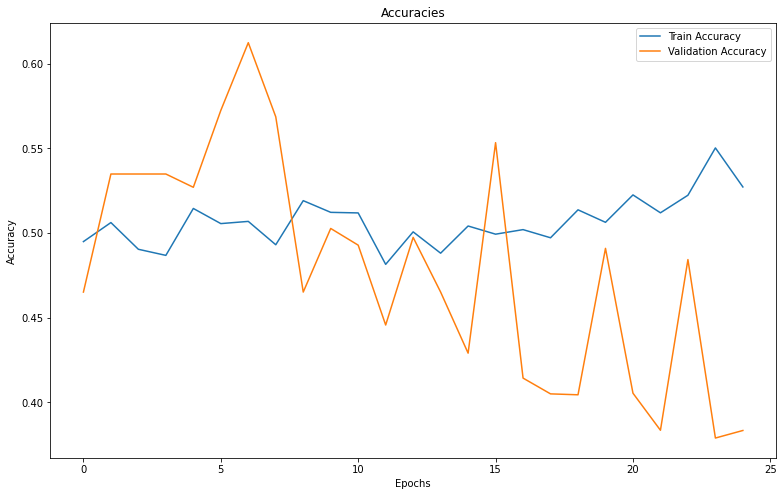

In [25]:
plt.figure(figsize = (13,8))
plt.plot(history.history["auc_1"], label = "Train Accuracy")
plt.plot(history.history["val_auc_1"],label = "Validation Accuracy")
plt.title("Accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

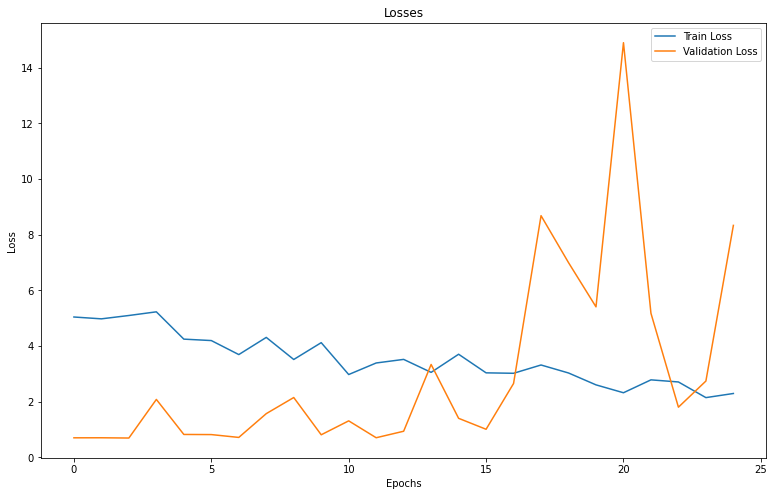

In [26]:
plt.figure(figsize = (13,8))
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.title("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
X_test = tf.expand_dims(X_test, axis=-1)

In [ ]:
y_pred = model.predict(X_test) #predict test
pred = np.argmax(y_pred, axis = 1)

result = pd.DataFrame(test_idt)
result[1] = pred

result.columns=["BraTS21ID","MGMT_value"]
result_final = result.groupby("BraTS21ID",as_index = False).mean()

result_final["BraTS21ID"] = sample_sub["BraTS21ID"]
result_final["MGMT_value"] = result_final["MGMT_value"]
result_final

ValueError: ignored

In [ ]:
result

,0
0,20
1,734
2,481
3,792
4,556
...,...
868,528
869,488
870,99
871,32
